# IMPORT ALL IMPORTANT LIBRARITES



In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers

In [2]:
import matplotlib.pyplot as plt

In [ ]:
!pip install --upgrade Pillow

# DEFINE IMPORTANT VARIABLES

In [22]:
BATCH_SIZE = 32
IMAGE_SIZE = 256 
CHANNELS=3
EPOCHS=30

# IMPORT DATASET FROM DIRECTORY

In [5]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


# LOOK AT ALL CLASS NAMES

In [6]:
classnames = data.class_names
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# VIEW IMAGES

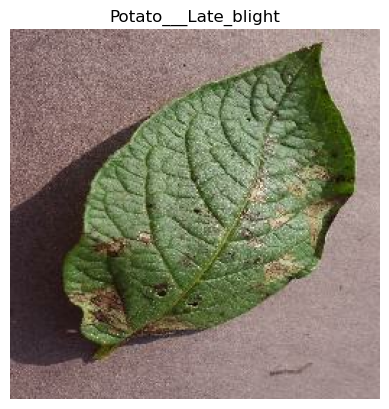

In [7]:
for image_batch, labels_batch in data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(classnames[labels_batch[0]])
    plt.axis('off')

# TRAIN TEST SPLIT

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data)

In [10]:
print(len(train_ds),len(test_ds),len(val_ds))

54 8 6


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# RESCALING

In [1]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

NameError: name 'tf' is not defined

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# MODEL

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# TRAINING

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30


54/54 [==============================] - 50s 822ms/step - loss: 1.1591 - accuracy: 0.4890 - val_loss: 0.8679 - val_accuracy: 0.6875
Epoch 2/30
54/54 [==============================] - 40s 730ms/step - loss: 0.7819 - accuracy: 0.6215 - val_loss: 0.7130 - val_accuracy: 0.6615
Epoch 3/30
54/54 [==============================] - 41s 751ms/step - loss: 0.5343 - accuracy: 0.7703 - val_loss: 0.6171 - val_accuracy: 0.7500
Epoch 4/30
54/54 [==============================] - 43s 785ms/step - loss: 0.3461 - accuracy: 0.8559 - val_loss: 0.3472 - val_accuracy: 0.8490
Epoch 5/30
54/54 [==============================] - 39s 725ms/step - loss: 0.2642 - accuracy: 0.8947 - val_loss: 0.2723 - val_accuracy: 0.8854
Epoch 6/30
54/54 [==============================] - 37s 680ms/step - loss: 0.2452 - accuracy: 0.9034 - val_loss: 0.2690 - val_accuracy: 0.8542
Epoch 7/30
54/54 [==============================] - 38s 694ms/step - loss: 0.2552 - accuracy: 0.8964 - val_loss: 0.4318 - val_accuracy: 0.83

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 150ms/step - loss: 0.4650 - accuracy: 0.8633


In [19]:
scores

[0.4804483652114868, 0.8467881679534912]

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

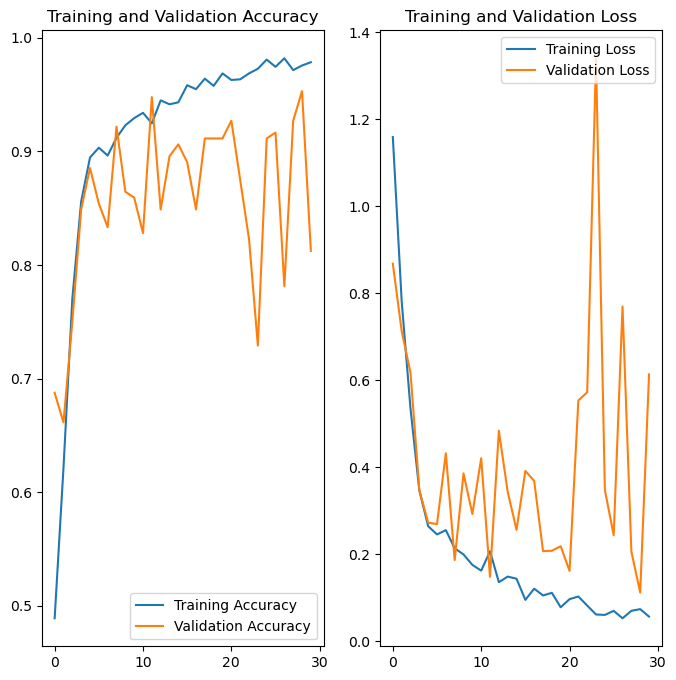

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# PREDICTION

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 434ms/step
predicted label: Potato___Early_blight


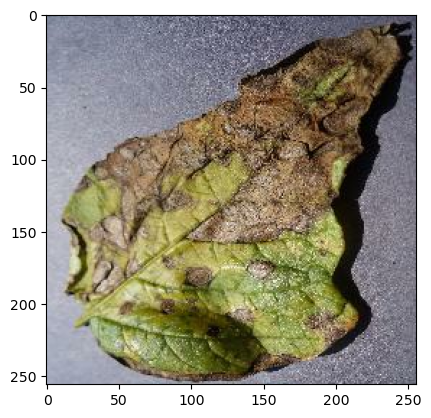

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# VISUALIZING THE OUTPUT

1/1 [==============================] - 0s 39ms/step


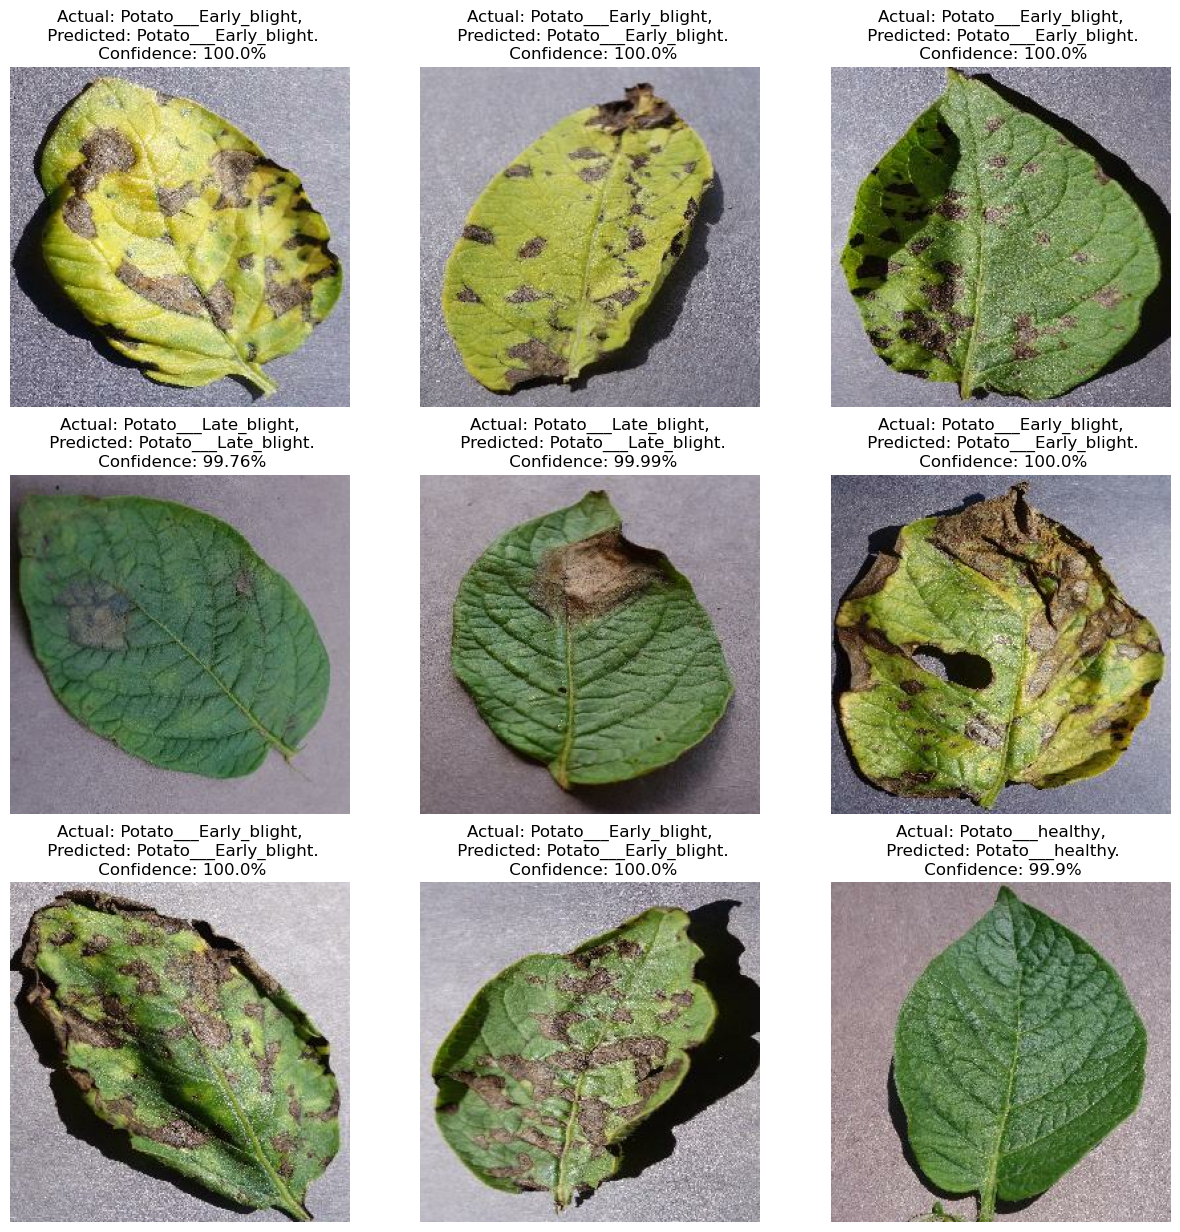

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classnames[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
import os
model_version=max([int(i) for i in os.listdir("./model") + [0]])+1
model.save(f"./model/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: './model'

# SAVING THE MODEL

In [28]:
model.save("../plant.h5")

C:\Users\yahya\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# MODEL SUMMARY

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

1/1 [==============================] - 0s 412ms/step


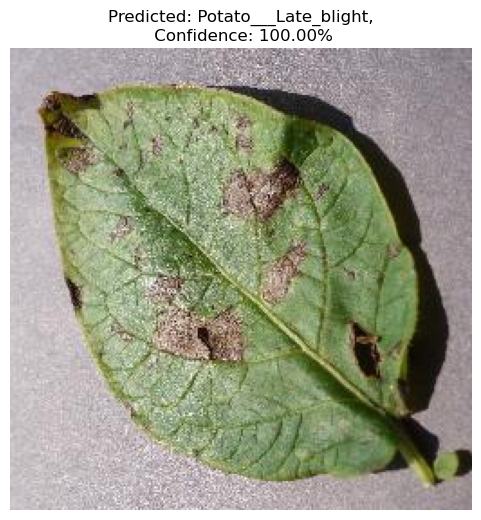

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model(r"E:/Projects/FDA_PROJECT/backened/plant.h5")

# Function to preprocess a single image
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Function to predict a single image
def predict_single_image(image_path, model):
    image = preprocess_image(image_path)
    predictions = model.predict(image)
    predicted_class_idx = tf.argmax(predictions[0]).numpy()
    confidence = predictions[0][predicted_class_idx] * 100
    predicted_class = classnames[predicted_class_idx]
    return predicted_class, confidence

# Example usage for one image
image_path = "E:/Projects/FDA_PROJECT/backened/testing/1.JPG"
classnames = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
  # Replace with your class names
predicted_class, confidence = predict_single_image(image_path, model)

# Plotting the image and prediction
plt.figure(figsize=(6, 6))
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
plt.imshow(image)
plt.title(f"Predicted: {predicted_class},\n Confidence: {confidence:.2f}%")
plt.axis("off")
plt.show()
